<a href="https://colab.research.google.com/github/viswavich/DLTBACS-PROJECT/blob/main/DLTBACS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q pandas numpy scikit-learn tensorflow shap matplotlib seaborn

In [ ]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import load_model

In [ ]:
df = pd.read_csv("/IT_Company_1000_Employees.csv")

# Encode categorical columns
label_cols = ['DEPT', 'ROLE', 'ACCESS_TIME', 'DEVICE_TRUST', 'RESOURCE_TYPE', 'SENSITIVITY_LEVEL']
encoders = {}

for col in label_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    encoders[col] = le  # Save encoder

# Prepare features and labels
X = df.drop(columns=['EMP_ID', 'RESOURCE_ID', 'ACTION'])
y = df['ACTION']

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Lightweight model with fewer parameters
model = Sequential()
model.add(Dense(32, input_shape=(X.shape[1],), activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=25, batch_size=16, validation_split=0.2)

Epoch 1/25


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5451 - loss: 0.6895 - val_accuracy: 0.6125 - val_loss: 0.6491
Epoch 2/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6187 - loss: 0.6479 - val_accuracy: 0.6562 - val_loss: 0.6388
Epoch 3/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6499 - loss: 0.6291 - val_accuracy: 0.6687 - val_loss: 0.6313
Epoch 4/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6703 - loss: 0.6088 - val_accuracy: 0.6875 - val_loss: 0.6330
Epoch 5/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7319 - loss: 0.5691 - val_accuracy: 0.6938 - val_loss: 0.6096
Epoch 6/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7053 - loss: 0.5720 - val_accuracy: 0.6812 - val_loss: 0.6073
Epoch 7/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6867 - loss: 0.5808 - val_accuracy: 0.6938 - val_loss: 0.6221
Epoch 8/25
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7123 - loss: 0.5468 - val_accuracy: 0.6687 - val_loss: 0.6090
Epo

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

y_pred = (model.predict(X_test) >= 0.5).astype(int)
print(classification_report(y_test, y_pred))

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6943 - loss: 0.5620  
Test Accuracy: 69.50%
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
              precision    recall  f1-score   support

           0       0.80      0.43      0.56        90
           1       0.66      0.91      0.77       110

    accuracy                           0.69       200
   macro avg       0.73      0.67      0.66       200
weighted avg       0.72      0.69      0.67       200



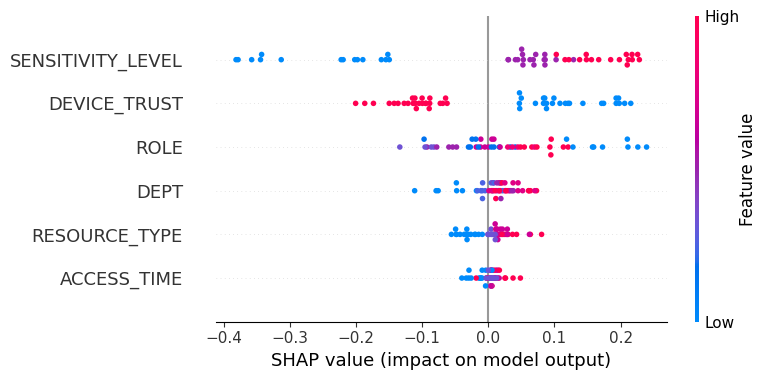

In [ ]:
# SHAP for Explainability
explainer = shap.Explainer(model, X_train.to_numpy())
shap_values = explainer(X_test[:50].to_numpy())

# SHAP summary plot
shap.summary_plot(shap_values, features=X_test[:50], feature_names=X.columns)

In [ ]:
def predict_access(input_data):
    pred_prob = model.predict(np.array(input_data).reshape(1, -1))[0][0]
    decision = "Access Granted ✅" if pred_prob >= 0.5 else "Access Denied ❌"
    return decision, pred_prob

# Example usage
sample = X_test.iloc[0].values
decision, score = predict_access(sample)
print("Decision:", decision)
print("Score:", round(score, 4))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
Decision: Access Granted ✅
Score: 0.975


In [ ]:
# Add small noise to simulate manipulated input
def generate_adversarial(input_data):
    noise = np.random.normal(0, 0.1, input_data.shape)
    return input_data + noise

adv_input = generate_adversarial(sample)
adv_decision, adv_score = predict_access(adv_input)
print("Adversarial Decision:", adv_decision)
print("Adversarial Score:", round(adv_score, 4))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
Adversarial Decision: Access Granted ✅
Adversarial Score: 0.9753


In [ ]:
model.save("dlbac_light_model.keras")

In [ ]:
!pip install streamlit
import streamlit as st
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model
from sklearn.preprocessing import LabelEncoder

# Load model
model = load_model("dlbac_light_model.h5")

# Simulated encoders for label columns
encoders = {}
label_values = {
    'DEPT': ['IT', 'HR', 'Finance', 'Operations', 'R&D'],
    'ROLE': ['Developer', 'Manager', 'Analyst', 'Admin', 'Engineer', 'Support', 'Consultant'],
    'ACCESS_TIME': ['Morning', 'Afternoon', 'Evening', 'Night'],
    'DEVICE_TRUST': ['Trusted', 'Untrusted'],
    'RESOURCE_TYPE': ['Database', 'File Server', 'Email System', 'Cloud App'],
    'SENSITIVITY_LEVEL': ['Low', 'Medium', 'High']
}

for col, values in label_values.items():
    le = LabelEncoder()
    le.fit(values)
    encoders[col] = le

# Streamlit App
st.title("DLBAC: AI-Based Access Control System")

st.header("🔐 Employee Sign In")

emp_id = st.text_input("Employee ID")
dept = st.selectbox("Department", label_values['DEPT'])
role = st.selectbox("Role", label_values['ROLE'])

if st.button("Continue"):
    st.success(f"Welcome {role} from {dept} department!")

    st.header("🗂️ Resource Access Request")

    access_time = st.selectbox("Access Time", label_values['ACCESS_TIME'])
    device_trust = st.selectbox("Device Trust Level", label_values['DEVICE_TRUST'])
    resource_type = st.selectbox("Resource Type", label_values['RESOURCE_TYPE'])
    sensitivity = st.selectbox("Sensitivity Level", label_values['SENSITIVITY_LEVEL'])

    if st.button("Request Access"):
        # Encode input
        inputs = [
            encoders['DEPT'].transform([dept])[0],
            encoders['ROLE'].transform([role])[0],
            encoders['ACCESS_TIME'].transform([access_time])[0],
            encoders['DEVICE_TRUST'].transform([device_trust])[0],
            encoders['RESOURCE_TYPE'].transform([resource_type])[0],
            encoders['SENSITIVITY_LEVEL'].transform([sensitivity])[0]
        ]

        pred = model.predict(np.array(inputs).reshape(1, -1))[0][0]
        decision = "✅ Access Granted" if pred >= 0.5 else "❌ Access Denied"
        st.subheader(decision)
        st.text(f"Confidence Score: {round(pred, 4)}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 79.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 85.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 8.1 MB/s eta 0:00:00


2025-05-08 11:52:44.549 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-08 11:52:44.734 
  command:

    streamlit run /usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-05-08 11:52:44.734 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-08 11:52:44.737 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-08 11:52:44.738 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-08 11:52:44.741 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-08 11:52:44.743 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-08 11:52:44.748 Thread 'MainThread': mi